In [1]:
import pandas as pd
import pickle
import nltk


geo = pd.read_excel('geo_comment.xlsx')
comment = geo['comment']

# Prepare text

First, we should lemmatize text, remove punctuation (leave only dots)

### Yandex Mystem

In [39]:
from pymystem3 import Mystem


def lemma(word):    
    m = Mystem()
    return m.lemmatize(word)[0]

### Better use Morphy

In [ ]:
import pymorphy2


def lemma(word):
    morph = pymorphy2.MorphAnalyzer()
    p = morph.parse(word)[0]
    return p.normal_form

In [35]:
%%time
def clean_text(text):
    parts = nltk.word_tokenize(text)
    
    restrict_parts = [':', ',', ';']
    
    # allow punctuation
    punct = ['.', '-']
    
    result = ''
    
    for part in parts:
        if part not in restrict_parts:
            if part in punct:
                word = part
            
            # lemmatize
            else:
                word = lemma(part) 
            result += ' ' + word
    
    return result
    
    
#comment['comment'] = comment['comment'].apply(clean_text)
new_comment = []
for c in comment:
    new_comment.append(clean_text(c))

Wall time: 4min 15s


# Document-term matrix

In [4]:
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
import nltk

# we must remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words('russian')
with open('comment_stop_words.txt', encoding='utf-8') as f:
    our_stop_words = f.read().splitlines()
    f.close()

sw = sw + our_stop_words

# We will remove digits
word_pattern = r'[a-zA-Zа-яА-Я]+'

cv = CountVectorizer(stop_words= sw, token_pattern=word_pattern)
data_cv = cv.fit_transform(comment)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

#del cv
#del data_cv

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\melts\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Save document term matrix to file
Need a lot of memory for saving it as Dataframe. So we save it as sparse matrix

In [5]:
f = open('dtm.pkl', 'wb')
pickle.dump(data_cv, f)
f.close()

# save countvectorizer
f = open('cv.pkl', 'wb')
pickle.dump(cv, f)
f.close()

# Load document term matrix

In [ ]:
f = open('dtm.pkl', 'wb')
data_dtm = pickle.load(f)
f.close()

In [3]:
print('Text count: ', data_dtm.shape[0], ' Word count: ', data_dtm.shape[1])

Text count:  70382  Word count:  30700


# Word stats

In [11]:
%%time

words = {}

for word in data_dtm.columns:
    # first lemmatize colum
    w = lemma(word)
    
    if w in words:
        words[w] += data_dtm[word].sum()
    else:
        words[w] = data_dtm[word].sum() 

# save to DF, sort
w = pd.DataFrame.from_dict(words, orient='index')
w.sort_values(by=0,ascending=False, inplace=True)

Wall time: 25min 23s


In [12]:
# save to csv
w.to_csv('word_stats.csv', encoding='utf-8')

f = open('words.pkl', 'wb')
pickle.dump(words, f)
f.close()

In [11]:
f = open('words.pkl', 'rb')
words = pickle.load(f)
f.close()

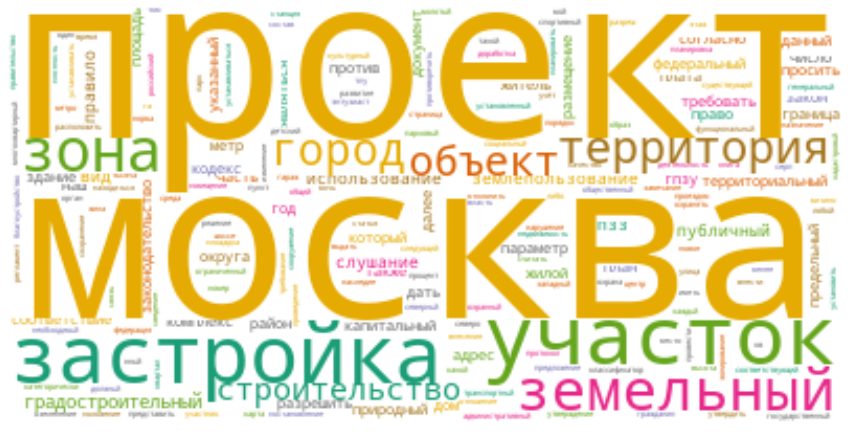

In [14]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize=(15,12))

wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

wc = wc.generate_from_frequencies(words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

# Look at freq of words
First of all, i've added some words for our stop dictionary.

As we see, most the messages are related to land use and construction.

# Chunking

In [17]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

import itertools

# uncomment for the first run
# nltk.download('punkt')

In [23]:
%%time

# load sentences tokenizer
sent_token = nltk.data.load('tokenizers/punkt/russian.pickle')

# each comment to sentences
sentences = comment.apply(sent_token.tokenize)

# concencate in one list
sentences = itertools.chain.from_iterable(sentences.tolist())

# tokenize to words as gensim accept sentences in list of words format
sent_list = []
for sent in sentences:
    sent_list += [nltk.word_tokenize(sent)]

Wall time: 5min 16s


In [ ]:
%%time

# create phrases     
phrases = Phrases(sent_list, min_count=10, threshold=10)

In [27]:
# test phrases
t_s = 'Как активный гражданин голосую за зону развития по адресу: Новодевичий проезд вл.6, стр.2 и Погодинская ул., вл.22,стр.3(земельный участок, кад. номер77:01:0005006:1007)для строительства медицинского центра, детского сада жилого многопрофильного дома, общ. наз., площади до 25000кв.м., высотой до 47,25 м., с предельн. плотностью застройки до 25000кв.м. на 1 га территории с обеспечением машиномест и гаражом согласно действующим нормативам с площадью застройки земельного участка до 60 %.   2) установить зону развития по адресу : Дашков пер., вл.7, и ул. Тимура Фрунзе, вл.32 (зем. уч. кад. номер     77:01:0005015:3030 и 77:01:0005015:3029) для строительства лечебного центра общей наземной площадью до 3800кв.м. , высотой до 35м и гаражом   до 1300кв.м. с предельной плотностью застройки до 35000кв.м. на 1 га территории'

t_s = nltk.word_tokenize(t_s)
    
phrases[t_s]

['Как',
 'активный',
 'гражданин',
 'голосую',
 'за',
 'зону',
 'развития',
 'по',
 'адресу',
 ':',
 'Новодевичий_проезд',
 'вл.6',
 ',',
 'стр.2',
 'и',
 'Погодинская',
 'ул.',
 ',',
 'вл.22',
 ',',
 'стр.3',
 '(',
 'земельный',
 'участок',
 ',',
 'кад',
 '.',
 'номер77:01:0005006:1007',
 ')',
 'для',
 'строительства',
 'медицинского_центра',
 ',',
 'детского_сада',
 'жилого',
 'многопрофильного',
 'дома',
 ',',
 'общ',
 '.',
 'наз.',
 ',',
 'площади',
 'до',
 '25000кв.м.',
 ',',
 'высотой',
 'до',
 '47,25',
 'м.',
 ',',
 'с',
 'предельн',
 '.',
 'плотностью',
 'застройки',
 'до',
 '25000кв.м',
 '.',
 'на',
 '1',
 'га',
 'территории',
 'с',
 'обеспечением_машиномест',
 'и',
 'гаражом',
 'согласно',
 'действующим',
 'нормативам',
 'с',
 'площадью',
 'застройки',
 'земельного',
 'участка',
 'до',
 '60',
 '%',
 '.',
 '2',
 ')',
 'установить',
 'зону',
 'развития',
 'по',
 'адресу',
 ':',
 'Дашков_пер.',
 ',',
 'вл.7',
 ',',
 'и',
 'ул',
 '.',
 'Тимура_Фрунзе',
 ',',
 'вл.32',
 '(',
 'зем

# Topic modeling
* LDA
* LSI (Latent Semantic Indexing)
* NMF Non-Negative Matrix Factorization 

## LDA
As it in video

In [15]:
%%time
from gensim import matutils, models
import scipy.sparse

# we have to transpose
# convert from df to sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm.transpose())

# sparse matrix to corpus
corpus = matutils.Sparse2Corpus(sparse_counts)

corpus

In [18]:
f = open('sparse2corpus.pkl', 'wb')
pickle.dump(corpus, f)
f.close()

In [37]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda.print_topics()

[(0,
  '0.110*"москвы" + 0.073*"города" + 0.046*"землепользования" + 0.034*"округа" + 0.030*"административном" + 0.029*"северо" + 0.027*"западном" + 0.026*"территории" + 0.025*"правил" + 0.021*"функциональной"'),
 (1,
  '0.034*"против" + 0.030*"категорически" + 0.029*"территории" + 0.020*"героев" + 0.018*"проект" + 0.018*"придомовой" + 0.017*"д" + 0.016*"застройки" + 0.016*"внутри" + 0.013*"строительства"'),
 (2,
  '0.074*"территории" + 0.056*"шоссе" + 0.036*"требуем" + 0.030*"серп" + 0.030*"молот" + 0.030*"энтузиастов" + 0.021*"комплекса" + 0.019*"процентом" + 0.019*"отвести" + 0.019*"вал"'),
 (3,
  '0.031*"панфиловцев" + 0.027*"дома" + 0.021*"проекта" + 0.021*"жителей" + 0.021*"территории" + 0.021*"свободы" + 0.020*"адресу" + 0.018*"д" + 0.016*"жилого" + 0.015*"проект"'),
 (4,
  '0.017*"москвы" + 0.016*"использования" + 0.015*"земельных" + 0.015*"участков" + 0.014*"кодекса" + 0.014*"градостроительного" + 0.013*"города" + 0.013*"пзз" + 0.012*"москве" + 0.011*"соответствии"'),
 (5,
  '